In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pandas_datareader as web

Get data of company using the specified API from 'start' to 'end' dates

In [2]:
start_date, end_date = "2000-01-01", "2021-12-31"
df = web.DataReader("TSLA", 'yahoo', start=start_date, end=end_date)

In [3]:
# goal is to predict closing prices
data = df.filter(['Close'])

In [4]:
# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_array = scaler.fit_transform(data) # numpy array

In [5]:
# create DataFrame from scaled array
scaled_data = pd.DataFrame()
scaled_data['Close'] = pd.DataFrame(scaled_data_array)

In [6]:
# use 75% of data to train the model
train_data_size = int(len(data) * 0.75)
print(train_data_size)

2174


In [7]:
# partition data into train and test data
train_data = scaled_data[0:train_data_size]
test_data = scaled_data[train_data_size:]

In [8]:
train_data_array = np.array(train_data)
train_data_array.shape

(2174, 1)

Split training data into inputs and targets

In [9]:
trail = 90 # number of days used to make prediction
x_train, y_train = [], []
for i in range(trail, train_data_array.shape[0]):
    x_train.append(train_data_array[i-trail:i])  # input will be closing prices from last 90 days
    y_train.append(train_data_array[i,0])       # target will be closing price one day after

In [10]:
# convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
x_train.shape, y_train.shape

((2084, 90, 1), (2084,))

Note that x_train and y_train have the closing prices up to 'memory' days before test_data begins

In [12]:
train_data.shape[0], train_data.shape[0] - trail

(2174, 2084)

In [13]:
# build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.4))
# model.add(LSTM(units=70, return_sequences=True))
# model.add(Dropout(0.4))
# model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=1))

Metal device set to: Apple M1


2021-12-31 23:09:15.285933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-31 23:09:15.286035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# train the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5)

2021-12-31 23:09:15.486486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2021-12-31 23:09:16.132478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 23:09:16.338060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 23:09:16.472143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 23:09:16.632175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 23:09:16.888192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 5s 55ms/step - loss: 1.3067e-04
Epoch 2/5
66/66 [==============================] - 3s 48ms/step - loss: 6.0885e-05
Epoch 3/5
66/66 [==============================] - 3s 49ms/step - loss: 7.4079e-05
Epoch 4/5
66/66 [==============================] - 3s 48ms/step - loss: 6.1046e-05
Epoch 5/5
66/66 [==============================] - 3s 48ms/step - loss: 4.7070e-05


# Organize test data

Due to the 90 day gap, test_data must include the following

In [15]:
test_data.head()

,Close
2174,0.047253
2175,0.046751
2176,0.044904
2177,0.045471
2178,0.046133


Adjust test_data accordingly

In [16]:
test_data_adj = train_data.tail(trail).append(test_data)

In [17]:
# prepare array of test_data to make inputs and targets
test_data_array = np.array(test_data_adj)

In [18]:
x_test, y_test = [], []
for i in range(trail, test_data_array.shape[0]):
    x_test.append(test_data_array[i-trail:i])
    y_test.append(test_data_array[i])

In [19]:
# verify
len(x_test), len(y_test), test_data.shape, test_data.shape[0]

(725, 725, (725, 1), 725)

In [20]:
# prepare inputs and targets to be read
x_test, y_test = np.array(x_test), np.array(y_test)

In [21]:
# verify dims
x_test.shape, y_test.shape

((725, 90, 1), (725, 1))

In [22]:
scaled_predictions = model.predict(x_test) 
scaled_predictions

2021-12-31 23:09:33.694875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 23:09:33.759046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 23:09:33.874174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.04794849],
       [0.04784612],
       [0.04769667],
       [0.04734416],
       [0.04700708],
       [0.04678632],
       [0.04662318],
       [0.04680315],
       [0.04719763],
       [0.04719339],
       [0.04686019],
       [0.04626577],
       [0.04562239],
       [0.04503433],
       [0.04467062],
       [0.0445626 ],
       [0.04444232],
       [0.04443238],
       [0.04448877],
       [0.04430991],
       [0.04394794],
       [0.04351287],
       [0.04320317],
       [0.04298927],
       [0.04267151],
       [0.04227536],
       [0.04202029],
       [0.04197809],
       [0.04209821],
       [0.04229684],
       [0.04267289],
       [0.04302301],
       [0.04342692],
       [0.04338247],
       [0.04328166],
       [0.04313534],
       [0.04296802],
       [0.04287724],
       [0.04269321],
       [0.04247946],
       [0.04225454],
       [0.0421732 ],
       [0.04212382],
       [0.04213043],
       [0.04197382],
       [0.04178875],
       [0.0415193 ],
       [0.041

In [23]:
predictions = scaler.inverse_transform(scaled_predictions)
predictions

array([[  61.980816],
       [  61.855225],
       [  61.671894],
       [  61.239452],
       [  60.825943],
       [  60.55512 ],
       [  60.354984],
       [  60.57577 ],
       [  61.05969 ],
       [  61.054497],
       [  60.645737],
       [  59.91653 ],
       [  59.127274],
       [  58.40586 ],
       [  57.959682],
       [  57.82717 ],
       [  57.679615],
       [  57.667423],
       [  57.736595],
       [  57.51719 ],
       [  57.07314 ],
       [  56.53941 ],
       [  56.15949 ],
       [  55.897087],
       [  55.50728 ],
       [  55.0213  ],
       [  54.708393],
       [  54.65662 ],
       [  54.803978],
       [  55.047653],
       [  55.508965],
       [  55.93848 ],
       [  56.43397 ],
       [  56.37945 ],
       [  56.255775],
       [  56.076275],
       [  55.87102 ],
       [  55.75966 ],
       [  55.5339  ],
       [  55.27167 ],
       [  54.995766],
       [  54.895973],
       [  54.835403],
       [  54.84351 ],
       [  54.651386],
       [  

In [24]:
# compute error
rmse = np.sqrt(np.mean(scaled_predictions - y_test)**2) # root mean squared error
rmse

0.025970624445544318

# Prepare data to be plotted

In [25]:
train = data[:train_data_size]
test = data[train_data_size:] # should have same length as predictions 
len(test)

725

In [26]:
# test

In [27]:
test.insert(loc=1, column='Predictions', value=predictions)
test

,Close,Predictions
Date,,
2019-02-19,61.127998,61.980816
2019-02-20,60.512001,61.855225
2019-02-21,58.245998,61.671894
2019-02-22,58.942001,61.239452
2019-02-25,59.754002,60.825943
...,...,...
2021-12-27,1093.939941,880.095947
2021-12-28,1088.469971,897.430786
2021-12-29,1086.189941,914.193970


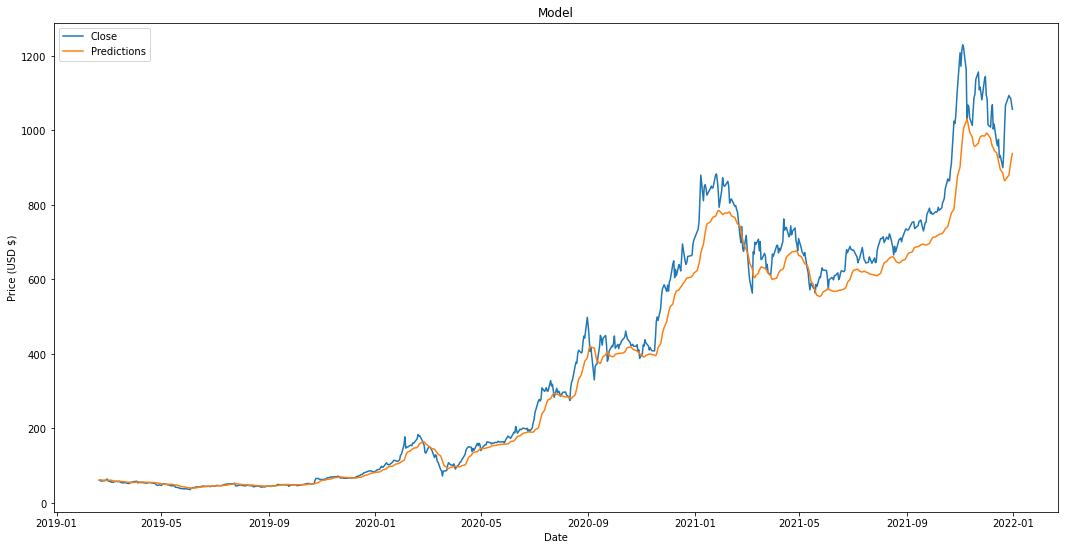

In [30]:
plt.figure(figsize=(18, 9))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Price (USD $)')
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc="upper left")
plt.show()